## Convert KINN K-A to KINN Eigen

**Note**: Eigen network needs TF2.X

In [1]:
%cd ..

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import amber
import src
from src.reload import reload_from_dir, get_rate_model_from_kinn
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder, KineticEigenModelBuilder
from src.model_spaces import get_cas9_uniform_ms, get_cas9_finkelstein_ms
from src.data import load_finkelstein_data as get_data

import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


Using TensorFlow backend.


detected tf2 - using compatibility mode


In [2]:
# load data
target = "wtCas9_cleave_rate_log"

matched = np.zeros((1,25,9))

wd = "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA1"
res = get_data(target=target, make_switch=wd.endswith("gRNA2"), logbase=10)
# unpack data tuple
(x_train, y_train), (x_test, y_test) = res

In [3]:
# load kinn
kinn_model_space = get_cas9_finkelstein_ms()

# manager configs
manager_kwargs={
    'output_op': 
        lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 10**-5, 10**-1))/np.log(10), name="output_log10"),  # change the clip as well
        #lambda: tf.keras.layers.Dense(units=1, activation="linear", name="output_nonneg", kernel_constraint=tf.keras.constraints.NonNeg()),
    'n_feats': 25,
    'n_channels': 9,
    'batch_size': 128,
    'epochs': 30,
    'earlystop': 10,
    'verbose': 0
}


kinn_ka = reload_from_dir(wd=wd, manager_kwargs=manager_kwargs, model_fn=KineticNeuralNetworkBuilder)
layer_dict = {l.name:l for l in kinn_ka.model.layers}
kinn_ka_rate_mod = tf.keras.models.Model(inputs=kinn_ka.model.inputs, outputs=layer_dict['gather_rates'].output)
kinn_ka_rates = kinn_ka_rate_mod.predict(kinn_ka.blockify_seq_ohe(matched))
kinn_ka_layers_weights = {l.name:l.get_weights() for l in kinn_ka.model.layers}
y_ka_hat = kinn_ka.predict(x_test)

loaded searched model


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


kinn rate for matched

k_0 -0.33218035
k_1 0.3975166
k_2 0.03276875
k_3 0.12984243
k_4 0.62228805
k_5 -1.4885821
k_6 0.10532506


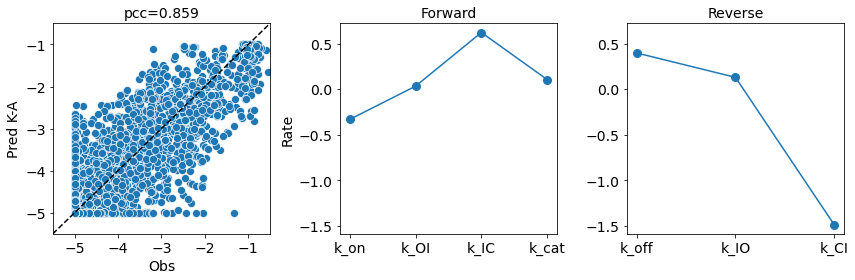

In [4]:
%matplotlib inline
fig, axs = plt.subplots(1,3, figsize=(12,4))
# 1. compare outputs to ground truth
ax = sns.scatterplot(x=y_test.flatten(), y=y_ka_hat.flatten(), ax=axs[0])
ax.set_xlabel('Obs')
ax.set_ylabel('Pred K-A')
ax.set_xlim(-5.5,-0.5)
ax.set_ylim(-5.5,-0.5)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="black")
ax.set_title('pcc=%.3f' % ss.pearsonr(y_ka_hat.flatten(), y_test.flatten())[0])

# 2.3. rates
rates = np.log10(np.exp(kinn_ka_rates.flatten()))
print("kinn rate for matched\n")
for i in range(7):
    r = rates[i]
    print("k_%i"%i, r)

rate_names = ['k_on', 'k_off', 'k_OI', 'k_IO', 'k_IC', 'k_CI', 'k_cat']
rate_df = pd.DataFrame({'rate': rates}, index=rate_names)
rate_df.loc[['k_on', 'k_OI', 'k_IC', 'k_cat']].plot(ax=axs[1], legend=False, style='-o', title="Forward", 
                                                    ylabel="Rate")
rate_df.loc[['k_off', 'k_IO', 'k_CI']].plot(ax=axs[2], legend=False, style='-o', title="Reverse")
rate_min, rate_max = rate_df['rate'].min(), rate_df['rate'].max()
axs[1].set_ylim(rate_min-0.1, rate_max+0.1)
axs[2].set_ylim(rate_min-0.1, rate_max+0.1)

fig.tight_layout()

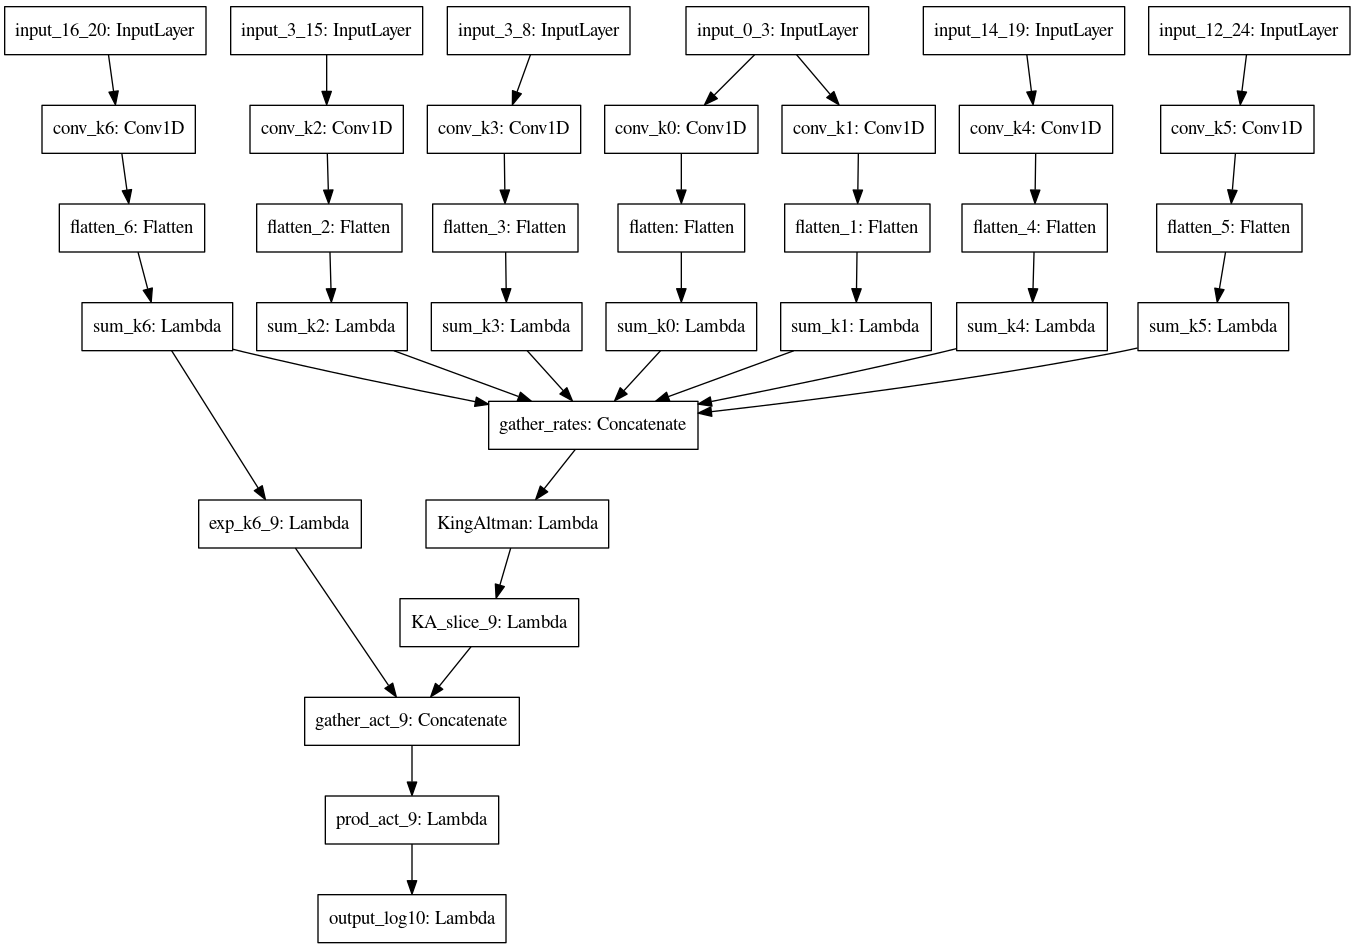

In [5]:
tf.keras.utils.plot_model(kinn_ka.model)

In [6]:
# train a new model and compare parameter robustness
%matplotlib inline
#tf.random.set_seed(0)
manager_kw2 = copy.copy(manager_kwargs)
manager_kw2['output_op'] = \
    lambda: tf.keras.layers.Dense(units=1, activation="linear", name="output_nonneg", kernel_constraint=tf.keras.constraints.NonNeg())
    #lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 10**-5, 10**-1))/np.log(10), name="output_log10")  # change the clip as well


kinn_ka2 = reload_from_dir(wd=wd, manager_kwargs=manager_kw2, model_fn=KineticNeuralNetworkBuilder,
            load_weights=False)
retrain = False
new_name_suffix = "linear_offset"
if retrain:
    t0 = time.time()
    checkpointer = tf.keras.callbacks.ModelCheckpoint( filepath=os.path.join(wd, f"bestmodel_{new_name_suffix}.h5"), mode='min', verbose=0, save_best_only=True, save_weights_only=True)
    earlystopper = tf.keras.callbacks.EarlyStopping( monitor="val_loss", mode='min', patience=50, verbose=0)
    x_train_b = kinn_ka2.blockify_seq_ohe(x_train)
    x_test_b = kinn_ka2.blockify_seq_ohe(x_test)

    hist = kinn_ka2.model.fit(
        x_train_b, y_train,
        epochs=3000,
        batch_size=128,
        validation_data=[x_test_b, y_test],
        callbacks=[checkpointer, earlystopper],
        verbose=0
    )
    kinn_ka2.model.load_weights(os.path.join(wd, f"bestmodel_{new_name_suffix}.h5"))
    print("training King-Altman network took %.3f seconds.." % (time.time() - t0))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
else:
    print("reloaded weights from disk..")
    kinn_ka2.model.load_weights(os.path.join(wd, f"bestmodel_{new_name_suffix}.h5"))   

# make predictions
y_ka_hat2 = kinn_ka2.predict(x_test)

reloaded weights from disk..


kinn rate for matched

k_0 0.4617589
k_1 0.45241374
k_2 1.6642363
k_3 1.3983713
k_4 2.1005542
k_5 -0.05724025
k_6 0.98012125


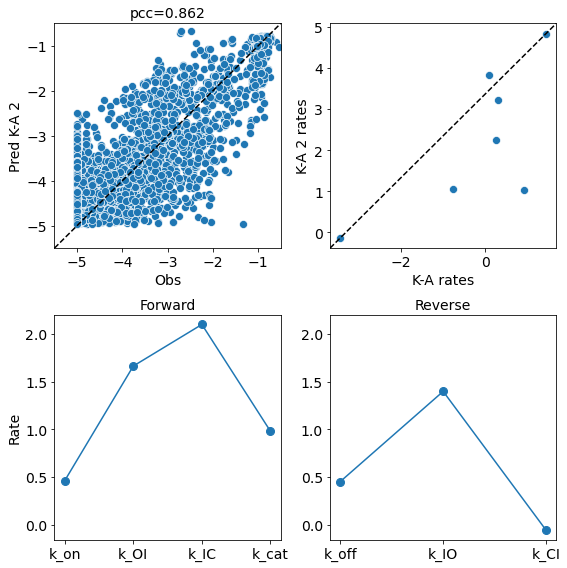

In [7]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
# 1. compare outputs to ground truth
ax = sns.scatterplot(x=y_test.flatten(), y=y_ka_hat2.flatten(), ax=axs[0,0])
ax.set_xlabel('Obs')
ax.set_ylabel('Pred K-A 2')
ax.set_xlim(-5.5,-0.5)
ax.set_ylim(-5.5,-0.5)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="black")
ax.set_title('pcc=%.3f' % ss.pearsonr(y_ka_hat2.flatten(), y_test.flatten())[0])
# 2. compare intermediate rates
kinn_ka_rate_mod2, kinn_ka_rates2 = get_rate_model_from_kinn(kinn=kinn_ka2)
ax = sns.scatterplot(y=kinn_ka_rates2.flatten(), x=kinn_ka_rates.flatten(), ax=axs[0,1])
ax.set_ylabel('K-A 2 rates')
ax.set_xlabel('K-A rates')
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="black")
#ax.set_title('pcc=%.3f' % ss.spearmanr(y_ka_hat2.flatten(), y_ka_hat.flatten())[0])
# 3.4. rates
rates = np.log10(np.exp(kinn_ka_rates2.flatten()))
print("kinn rate for matched\n")
for i in range(7):
    r = rates[i]
    print("k_%i"%i, r)

rate_names = ['k_on', 'k_off', 'k_OI', 'k_IO', 'k_IC', 'k_CI', 'k_cat']
rate_df = pd.DataFrame({'rate': rates}, index=rate_names)
rate_df.loc[['k_on', 'k_OI', 'k_IC', 'k_cat']].plot(ax=axs[1,0], legend=False, style='-o', title="Forward", 
                                                    ylabel="Rate")
rate_df.loc[['k_off', 'k_IO', 'k_CI']].plot(ax=axs[1,1], legend=False, style='-o', title="Reverse")
rate_min, rate_max = rate_df['rate'].min(), rate_df['rate'].max()
axs[1,0].set_ylim(rate_min-0.1, rate_max+0.1)
axs[1,1].set_ylim(rate_min-0.1, rate_max+0.1)

fig.tight_layout()

Text(0.5, 1.0, 'pcc=0.985')

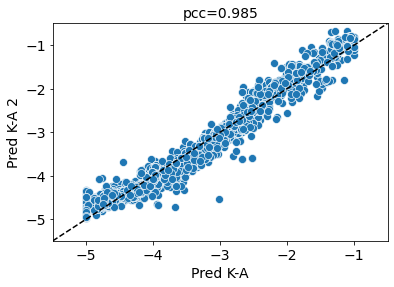

In [8]:
%matplotlib inline

ax = sns.scatterplot(x=y_ka_hat.flatten(), y=y_ka_hat2.flatten())
ax.set_xlabel('Pred K-A')
ax.set_ylabel('Pred K-A 2')
ax.set_xlim(-5.5,-0.5)
ax.set_ylim(-5.5,-0.5)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="black")
ax.set_title('pcc=%.3f' % ss.pearsonr(y_ka_hat2.flatten(), y_ka_hat.flatten())[0])

<AxesSubplot:title={'center':'pred_diff'}, xlabel='test_bin'>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


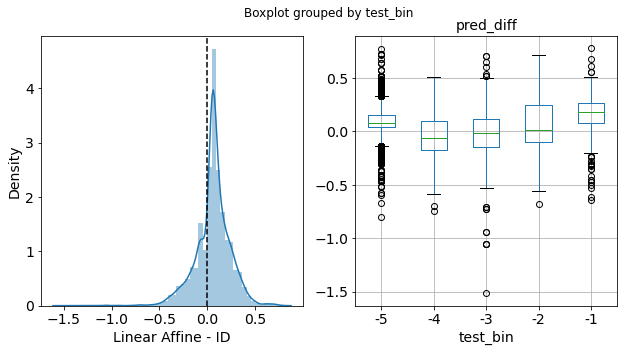

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
pred_diff = y_ka_hat2 - y_ka_hat
ax = sns.distplot(pred_diff, ax=axs[0])
ax.axvline(0, color='black', ls='--')
ax.set_xlabel('Linear Affine - ID')

plot_df = pd.DataFrame(dict(
    y_test=y_test.flatten(), 
    y_id = y_ka_hat.flatten(),
    y_aff = y_ka_hat2.flatten(),
    pred_diff=pred_diff.flatten()
))
plot_df['test_bin'] = pd.cut(plot_df['y_test'], np.arange(-5.5, 0, 1), labels=np.arange(-5,0,1))
plot_df.boxplot(column='pred_diff', by='test_bin', ax=axs[1])
#ax = sns.scatterplot(x=y_test.flatten(), y=pred_diff.flatten(), ax=axs[1])
#ax.axhline(0, color='black', ls='--')


In [10]:
# change the last rate to sink state
ka_bp = copy.copy(kinn_ka.kinn)
ka_bp.states = ['0', '1', '2', '3', '4']
ka_bp.rates[-1].__dict__['state_list'] = ['3', '4']
ka_bp.rates[-1].__dict__['scatter_nd'] = [((3,3), -1), ((4,3),  1), ]

# fix other scatter_nd, if needed
fix_scatter_nd = True
if fix_scatter_nd:
    scatter_ind = [
        [((0,0), -1), ((1,0),  1), ],
        [((0,1),  1), ((1,1), -1), ],
        [((1,1), -1), ((2,1),  1), ],
        [((1,2),  1), ((2,2), -1), ],
        [((2,2), -1), ((3,2),  1), ],
        [((2,3),  1), ((3,3), -1), ],
        [((3,3), -1), ((4,3),  1), ]
    ]
    for i, rate in enumerate(ka_bp.rates):
        rate.__dict__['scatter_nd'] = scatter_ind[i]

    
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
#tf.random.set_seed(0)
kinn_eig = KineticEigenModelBuilder(
    ka_bp, 
    n_feats=25, 
    n_channels=9,
    session=sess,
    output_op= 
        lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(tf.reshape(- x[:,1], (-1,1)), 10**-5, 10**-1))/np.log(10), name="output_slice")
        #lambda: tf.keras.layers.Dense(units=1, activation="linear", name="output_nonneg"),
)
kinn = kinn_eig

In [11]:
%matplotlib inline
retrain = False
kinn_eig.build(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

if retrain:
    t0 = time.time()

    checkpointer = tf.keras.callbacks.ModelCheckpoint( filepath=os.path.join(wd,"bestmodel_eigenvalue.h5"), mode='min', verbose=0, save_best_only=True, save_weights_only=True)
    earlystopper = tf.keras.callbacks.EarlyStopping( monitor="val_loss", mode='min', patience=50, verbose=0)
    x_train_b = kinn_eig.blockify_seq_ohe(x_train)
    x_test_b = kinn_eig.blockify_seq_ohe(x_test)

    hist = kinn_eig.model.fit(
        x_train_b, y_train,
        epochs=3000,
        batch_size=512,
        validation_data=[x_test_b, y_test],
        callbacks=[checkpointer, earlystopper],
        verbose=0
    )
    kinn_eig.model.load_weights(os.path.join(wd,"bestmodel_eigenvalue.h5"))
    print("training eigvalue network took %.3f seconds.." % (time.time() - t0))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
else:
    print("set weights from king-altman")
    for layer in kinn_eig.model.layers:
        if not layer.name.startswith('conv'): continue
        layer.set_weights(kinn_ka_layers_weights[layer.name])

# make predictions
y_eig_hat2 = kinn_eig.predict(x_test)

set weights from king-altman


In [12]:
y_eig_hat2 = kinn_eig.predict(x_test)
print(ss.spearmanr(y_test, y_ka_hat))
print(ss.spearmanr(y_test, y_eig_hat2))

SpearmanrResult(correlation=0.7961294243247574, pvalue=0.0)
SpearmanrResult(correlation=0.788252475575677, pvalue=0.0)


kinn rate for matched

k_0 -0.33218035
k_1 0.3975166
k_2 0.03276875
k_3 0.12984243
k_4 0.62228805
k_5 -1.4885821
k_6 0.10532506


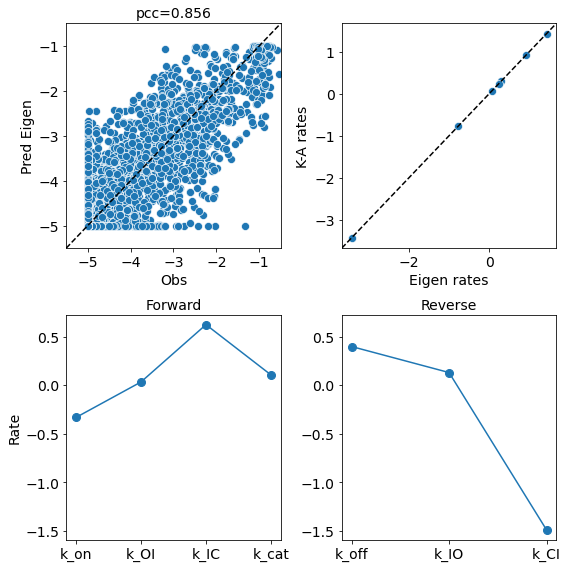

In [13]:
%matplotlib inline

fig, axs = plt.subplots(2,2, figsize=(8,8))
# 1. compare outputs
ax = sns.scatterplot(x=y_test.flatten(), y=y_eig_hat2.flatten(), ax=axs[0,0])
ax.set_xlabel('Obs')
ax.set_ylabel('Pred Eigen')
ax.set_xlim(-5.5,-0.5)
ax.set_ylim(-5.5,-0.5)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="black")
ax.set_title('pcc=%.3f' % ss.pearsonr(y_eig_hat2.flatten(), y_test.flatten())[0])
# 2. compare intermediate rates
kinn_eig_rate_mod2, kinn_eig_rates2 = get_rate_model_from_kinn(kinn=kinn_eig)
ax = sns.scatterplot(x=kinn_eig_rates2.flatten(), y=kinn_ka_rates.flatten(), ax=axs[0,1])
ax.set_xlabel('Eigen rates')
ax.set_ylabel('K-A rates')
#ax.set_xlim(-5.5,-0.5)
#ax.set_ylim(-5.5,-0.5)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="black")
#ax.set_title('pcc=%.3f' % ss.spearmanr(y_ka_hat2.flatten(), y_ka_hat.flatten())[0])

# 3.4. rates
rates = np.log10(np.exp(kinn_eig_rates2.flatten()))
print("kinn rate for matched\n")
for i in range(7):
    r = rates[i]
    print("k_%i"%i, r)

rate_names = ['k_on', 'k_off', 'k_OI', 'k_IO', 'k_IC', 'k_CI', 'k_cat']
rate_df = pd.DataFrame({'rate': rates}, index=rate_names)
rate_df.loc[['k_on', 'k_OI', 'k_IC', 'k_cat']].plot(ax=axs[1,0], legend=False, style='-o', title="Forward", 
                                                    ylabel="Rate")
rate_df.loc[['k_off', 'k_IO', 'k_CI']].plot(ax=axs[1,1], legend=False, style='-o', title="Reverse")
rate_min, rate_max = rate_df['rate'].min(), rate_df['rate'].max()
axs[1,0].set_ylim(rate_min-0.1, rate_max+0.1)
axs[1,1].set_ylim(rate_min-0.1, rate_max+0.1)

fig.tight_layout()

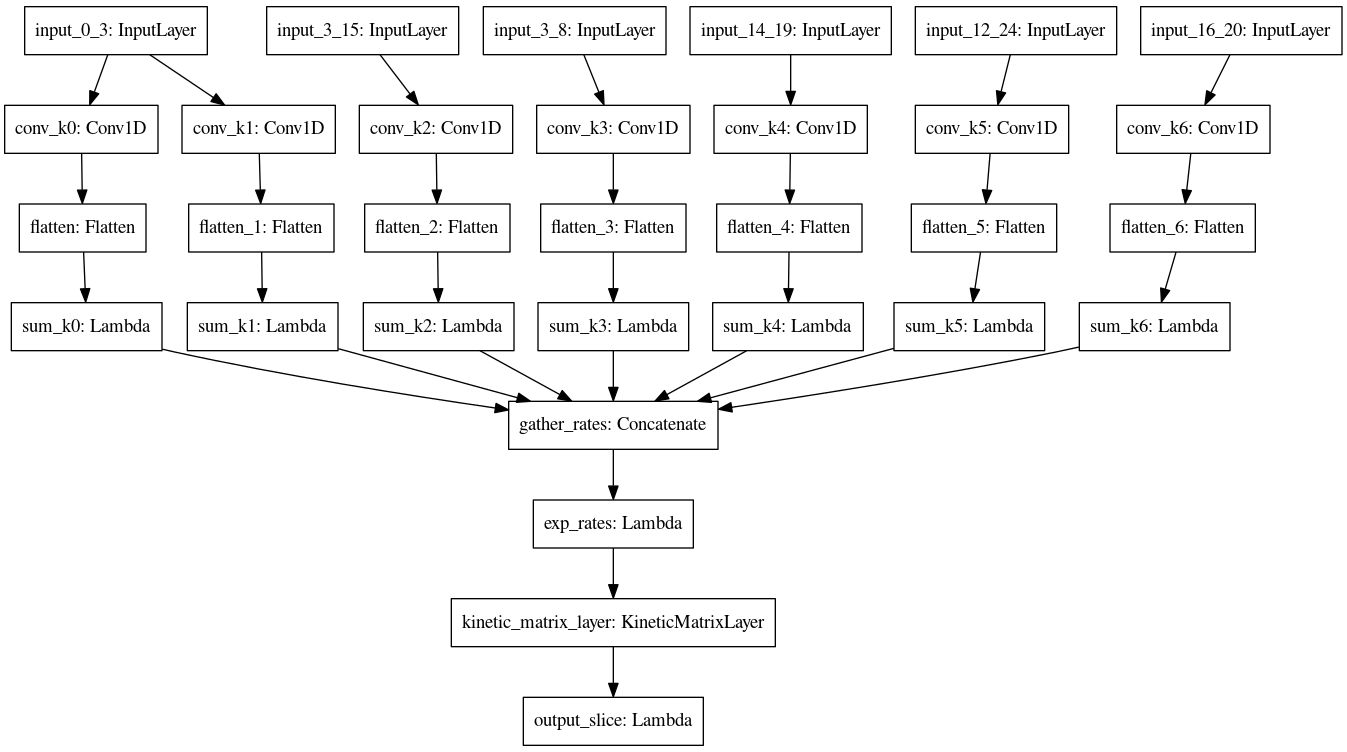

In [14]:
tf.keras.utils.plot_model(kinn_eig.model)

Text(0.5, 1.0, 'pcc=0.996')

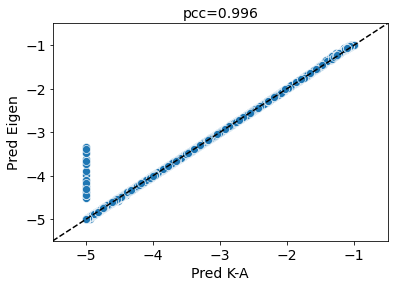

In [15]:
%matplotlib inline

ax = sns.scatterplot(x=y_ka_hat.flatten(), y=y_eig_hat2.flatten())
ax.set_xlabel('Pred K-A')
ax.set_ylabel('Pred Eigen')
ax.set_xlim(-5.5,-0.5)
ax.set_ylim(-5.5,-0.5)
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="black")
ax.set_title('pcc=%.3f' % ss.pearsonr(y_eig_hat2.flatten(), y_ka_hat.flatten())[0])

In [16]:
print(ss.spearmanr(y_test, y_ka_hat))
print(ss.spearmanr(y_test, y_ka_hat2))
print(ss.spearmanr(y_test, y_eig_hat2))

SpearmanrResult(correlation=0.7961294243247574, pvalue=0.0)
SpearmanrResult(correlation=0.7704104982290615, pvalue=0.0)
SpearmanrResult(correlation=0.788252475575677, pvalue=0.0)


In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.2.0

amber     : 0.1.2
pandas    : 1.4.2
seaborn   : 0.11.2
tensorflow: 2.4.1
numpy     : 1.21.5
src       : 0.0.1
matplotlib: 3.5.1
scipy     : 1.7.3

Watermark: 2.3.1

